In [90]:
# 변경된 모듈을 자동으로 다시 로드하도록 설정
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
import numpy as np
from qiskit import transpile
from qiskit_aer.primitives import SamplerV2

from src.noise_models import build_custom_noise_model
from src.qcluster import QClusterMitigator
from src.visualization import plot_mitigation_result, plot_pca_clusters, plot_3x1_histogram
from src.circuits import get_circuit



print("Libraries imported successfully!")

Libraries imported successfully!


Circuit created with 4 qubits.


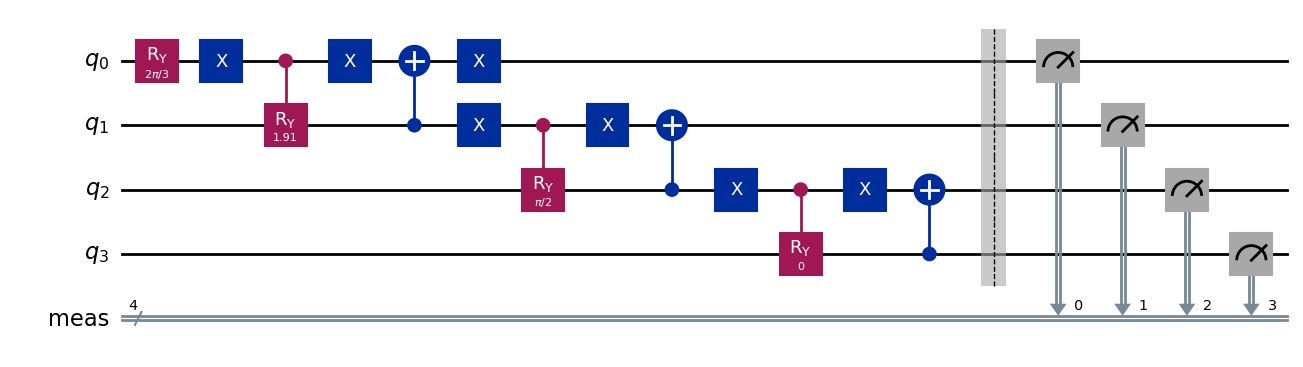

In [99]:
# 1. 하이퍼파라미터 설정
n_qubits = 4
n_shots = 2048
np.random.seed(42)

# 2. 회로 생성 (Sparse Block Ansatz)
qc = get_circuit('w_state', n_qubits=n_qubits)

# 4. Transpile
qc_transpiled = transpile(qc, optimization_level=0)
print(f"Circuit created with {n_qubits} qubits.")
qc.draw('mpl')

In [107]:
# [Ideal Simulation] 노이즈 없는 이상적인 결과
sampler_ideal = SamplerV2()
job_ideal = sampler_ideal.run([qc_transpiled], shots=n_shots)
counts_ideal = job_ideal.result()[0].data.meas.get_counts()

# [Noisy Simulation] Readout Error가 심한 환경 조성
noise_model = build_custom_noise_model(p_depol=0.05, p_readout=0.5) # p_readout=0.10 (10% 확률로 비트 반전)

sampler_noisy = SamplerV2()
sampler_noisy.options.simulator = {"noise_model": noise_model}

job_noisy = sampler_noisy.run([qc_transpiled], shots=n_shots)
pub_result = job_noisy.result()[0]

# 데이터 추출
bitstrings_noisy = pub_result.data.meas.get_bitstrings()
counts_noisy = pub_result.data.meas.get_counts()

print(f"Collected {len(bitstrings_noisy)} noisy shots.")
print(f"Top 5 Noisy Counts: {dict(list(counts_noisy.items())[:5])}...")

Collected 2048 noisy shots.
Top 5 Noisy Counts: {'0110': 780, '0010': 327, '0001': 85, '0000': 768, '0111': 88}...


In [108]:
# Q-Cluster 모델 초기화 (Cluster 개수 k는 튜닝 파라미터)
k_clusters = 2
mitigator = QClusterMitigator(k_clusters=k_clusters, max_iters=15)

# 학습 (Fit)
print("Running Q-Cluster algorithm...")
mitigator.fit(bitstrings_noisy)

# 완화 (Mitigate)
counts_mitigated = mitigator.mitigate(bitstrings_noisy)
centroids = mitigator.get_centroids()

print(f"Converged Centroids: {centroids}")
print("Mitigation Complete.")

Running Q-Cluster algorithm...
Converged Centroids: [np.str_('0000'), np.str_('0110')]
Mitigation Complete.


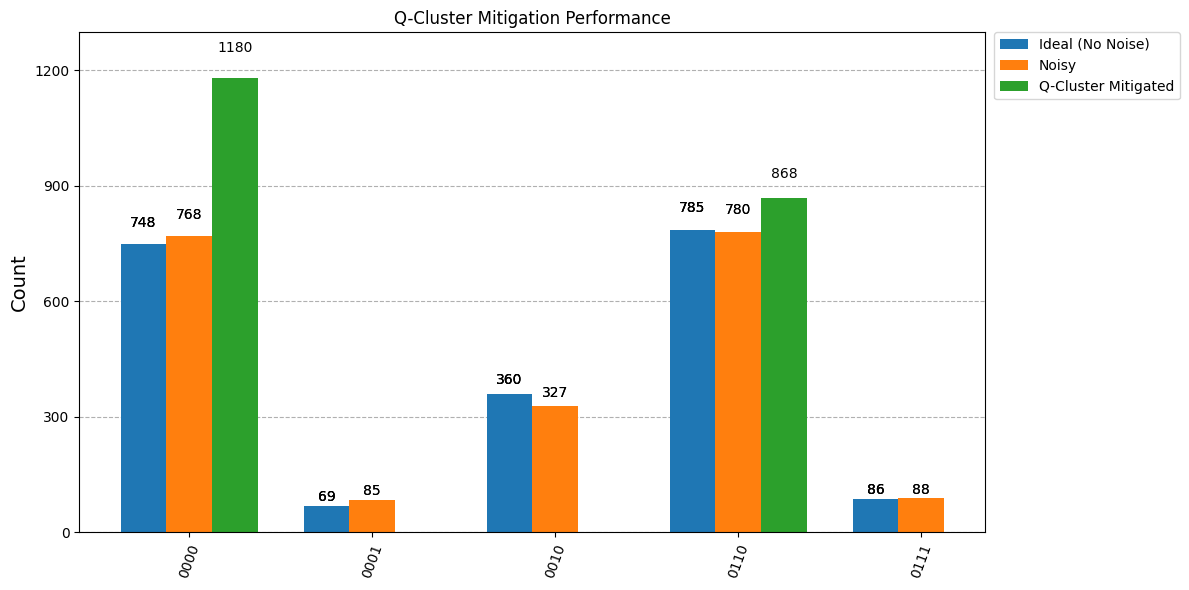

In [109]:
# Histogram 비교 시각화
plot_mitigation_result(counts_ideal, counts_noisy, counts_mitigated)

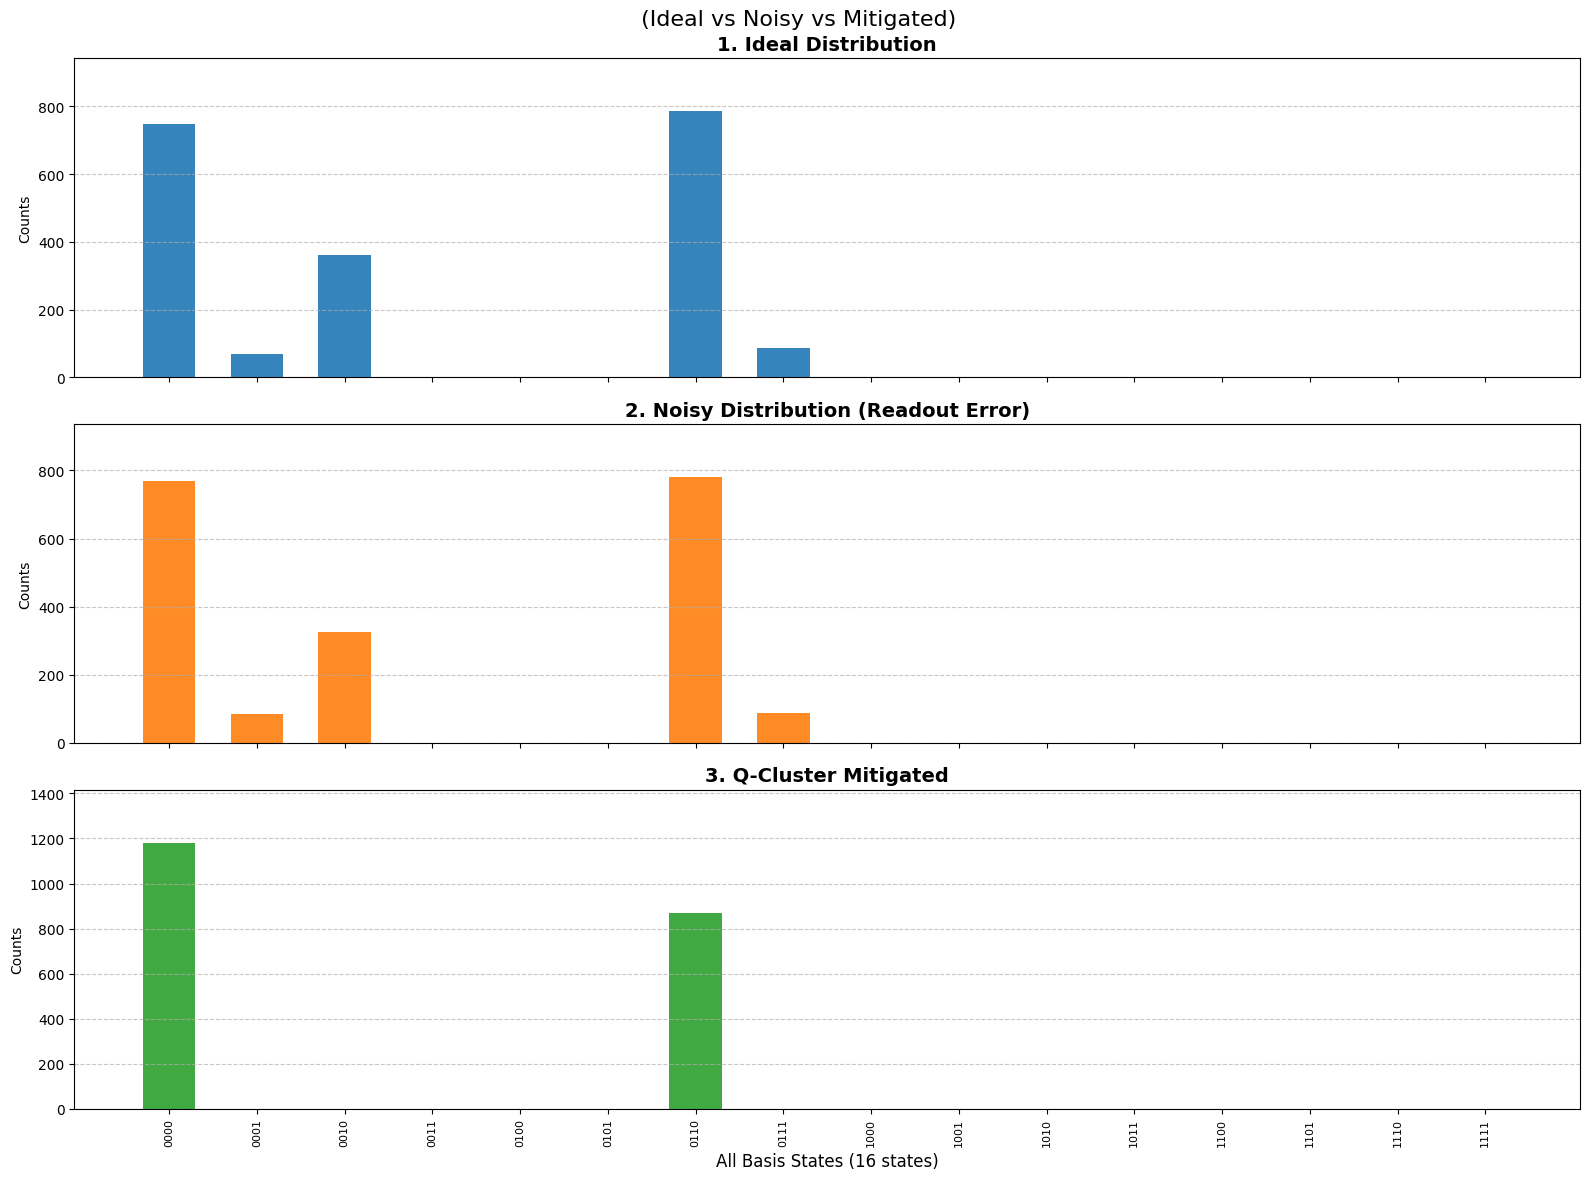

In [110]:
# 시각화2
plot_3x1_histogram(counts_ideal, counts_noisy, counts_mitigated, title=" (Ideal vs Noisy vs Mitigated)")

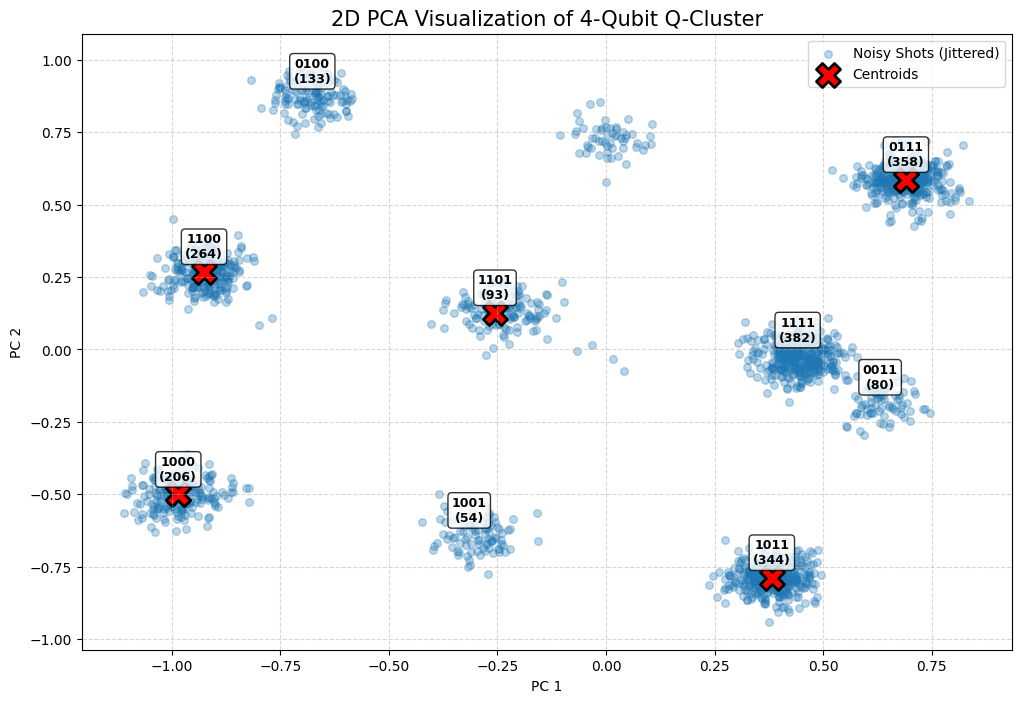

In [84]:
# PCA를 이용한 2D 시각화
plot_pca_clusters(bitstrings_noisy, centroids, counts_noisy, n_qubits)